# NLP for Stock Market Prediction
This code attempts to solve a Kaggle challenge that tries to predict stock market prices from news headers. A walk-through of the code can be found in this article: https://medium.com/analytics-vidhya/e2861d4a45a0

Kaggle challenge: https://www.kaggle.com/aaron7sun/stocknews

Kaggle article: https://www.kaggle.com/rahulvarma9595/nlp-for-stock-market-predictions

## Import packages and libraries

In [1]:
# import packages
import pandas as pd
import numpy as np
import string
import time
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

## Import data

In [2]:
pd.set_option('display.max_columns',7)

In [3]:
# import data
data = pd.read_csv('Combined_News_DJIA.csv')

print('data is %d data points with %d features'%(data.shape[0],data.shape[1]))
data.head()

data is 1989 data points with 27 features


,Date,Label,Top1,...,Top23,Top24,Top25
0,08/08/2008,0,"b""Georgia 'downs two Russian warplanes' as cou...",...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,11/08/2008,1,b'Why wont America and Nato help us? If they w...,...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,12/08/2008,0,b'Remember that adorable 9-year-old who sang a...,...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,13/08/2008,0,b' U.S. refuses Israel weapons to attack Iran:...,...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,14/08/2008,1,b'All the experts admit that we should legalis...,...,"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...


## Data preprocessing
### Data cleaning & tokenization & normalization

In [4]:
# data cleaning & tokenization & normalization
## create copy of original dataframe
dataClean = data.copy()

## create set for stopwords as dictionaries are faster
stops = set(stopwords.words('english'))

# news header you want to test
## (2,5) is interesting to see how "Al-Qa'eda" gets transferred
## (4,3) is interesting to see how numbers are encoded
## (2,15) is interesting to see how both numbers ('55') and hyphens ('mega-city') are encoded
## (1988,24) gives a bug for replacing numbers and removing stop words
tester = (2,5)

for i in range(2,data.shape[1]):
    if i==tester[1]:
        print('Original text:')
        print(dataClean.iloc[tester[0],i])
    
    # data cleaning
    ## remove 'b'' at the start and ''' at the end
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.strip("b'")
    if i==tester[1]:
        print('\nCleaned text:')
        print(dataClean.iloc[tester[0],i])
    
    ## remove punctuation
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.translate(str.maketrans('', '', string.punctuation))
    if i==tester[1]:
        print('\nPunctuations removed:')
        print(dataClean.iloc[tester[0],i])
        
    # normalization
    ## make lowercase
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.lower()
    if i==tester[1]:
        print('\nLowercase:')
        print(dataClean.iloc[tester[0],i])
    
    # tokenization
    ## word_tokenize version (buggy) is below
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.split()
    if i==tester[1]:
        print('\nTokenized:')
        print(dataClean.iloc[tester[0],i])
        
    # replace numbers
    dataClean.iloc[:,i]=dataClean.iloc[:,i].apply(lambda sent: 'num' if isinstance(sent,float) else ['num' if token.isdigit() else token for token in sent])
    if i==tester[1]:
        print('\nReplaced numbers:')
        print(dataClean.iloc[tester[0],i])
        print()
        
    # remove stop words
    dataClean.iloc[:,i]=dataClean.iloc[:,i].apply(lambda sent: [token for token in sent if token not in stops])
    if i==tester[1]:
        print('\nRemoved stop words:')
        print(dataClean.iloc[tester[0],i])
        

Original text:
b"Al-Qa'eda is losing support in Iraq because of a brutal crackdown on activities it regards as un-Islamic - including women buying cucumbers"

Cleaned text:
"Al-Qa'eda is losing support in Iraq because of a brutal crackdown on activities it regards as un-Islamic - including women buying cucumbers"

Punctuations removed:
AlQaeda is losing support in Iraq because of a brutal crackdown on activities it regards as unIslamic  including women buying cucumbers

Lowercase:
alqaeda is losing support in iraq because of a brutal crackdown on activities it regards as unislamic  including women buying cucumbers

Tokenized:
['alqaeda', 'is', 'losing', 'support', 'in', 'iraq', 'because', 'of', 'a', 'brutal', 'crackdown', 'on', 'activities', 'it', 'regards', 'as', 'unislamic', 'including', 'women', 'buying', 'cucumbers']

Replaced numbers:
['alqaeda', 'is', 'losing', 'support', 'in', 'iraq', 'because', 'of', 'a', 'brutal', 'crackdown', 'on', 'activities', 'it', 'regards', 'as', 'unisla

In [5]:
dataClean.head()

,Date,Label,Top1,...,Top23,Top24,Top25
0,08/08/2008,0,"[georgia, downs, two, russian, warplanes, coun...",...,"[indian, shoe, manufactory, series, like, work]","[visitors, suffering, mental, illnesses, banne...","[help, mexicos, kidnapping, surge]"
1,11/08/2008,1,"[wont, america, nato, help, us, wont, help, us...",...,"[perhaps, question, georgia, russia, conflict]","[russia, much, better, war]","[come, trading, sex, food]"
2,12/08/2008,0,"[remember, adorable, 9yearold, sang, opening, ...",...,"[christopher, king, argues, us, nato, behind, ...","[america, new, mexico]","[bbc, news, asiapacific, extinction, man, clim..."
3,13/08/2008,0,"[us, refuses, israel, weapons, attack, iran, r...",...,"[quarter, russians, blame, us, conflict, poll]","[georgian, president, says, us, military, take...","[num, nobel, laureate, aleksander, solzhenitsy..."
4,14/08/2008,1,"[experts, admit, legalise, drugs]",...,"[russia, world, forget, georgias, territorial,...","[darfur, rebels, accuse, sudan, mounting, majo...","[philippines, peace, advocate, say, muslims, n..."


### Stemming, lemmatization, canonicalization

In [6]:
# Stemming/lemmatization/canonicalization - Frank

# do either stemming or lemmatization
stemming = False # converted philippines to philippin in (4,25)
lemmatization = True # converts to proper words but philippine? (4,25)

dataNormal = dataClean.copy()
tester = (0,5) 
print('Original text:')
print(data.iloc[tester[0],tester[1]])
print('\nCleaned text:')
print(dataClean.iloc[tester[0],tester[1]])

if stemming:
    porter = PorterStemmer()   
    for i in range(2,dataNormal.shape[1]):
        dataNormal.iloc[:,i]=dataNormal.iloc[:,i].apply(lambda x: [porter.stem(y) for y in x])
    print('\nAfter stemming:')
    print(dataNormal.iloc[tester[0],tester[1]])
elif lemmatization:
    lemmatizer = WordNetLemmatizer()
    for i in range(2,data.shape[1]):
        dataNormal.iloc[:,i]=dataNormal.iloc[:,i].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
    print('\nAfter lemmatization:')
    print(dataNormal.iloc[tester[0],tester[1]])
        
print('\ndataNormal:')
dataNormal.head()

Original text:
b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire'

Cleaned text:
['russian', 'tanks', 'moving', 'towards', 'capital', 'south', 'ossetia', 'reportedly', 'completely', 'destroyed', 'georgian', 'artillery', 'fire']

After lemmatization:
['russian', 'tank', 'moving', 'towards', 'capital', 'south', 'ossetia', 'reportedly', 'completely', 'destroyed', 'georgian', 'artillery', 'fire']

dataNormal:


,Date,Label,Top1,...,Top23,Top24,Top25
0,08/08/2008,0,"[georgia, down, two, russian, warplane, countr...",...,"[indian, shoe, manufactory, series, like, work]","[visitor, suffering, mental, illness, banned, ...","[help, mexico, kidnapping, surge]"
1,11/08/2008,1,"[wont, america, nato, help, u, wont, help, u, ...",...,"[perhaps, question, georgia, russia, conflict]","[russia, much, better, war]","[come, trading, sex, food]"
2,12/08/2008,0,"[remember, adorable, 9yearold, sang, opening, ...",...,"[christopher, king, argues, u, nato, behind, g...","[america, new, mexico]","[bbc, news, asiapacific, extinction, man, clim..."
3,13/08/2008,0,"[u, refuse, israel, weapon, attack, iran, report]",...,"[quarter, russian, blame, u, conflict, poll]","[georgian, president, say, u, military, take, ...","[num, nobel, laureate, aleksander, solzhenitsy..."
4,14/08/2008,1,"[expert, admit, legalise, drug]",...,"[russia, world, forget, georgia, territorial, ...","[darfur, rebel, accuse, sudan, mounting, major...","[philippine, peace, advocate, say, muslim, nee..."


## Convert words to vectors
### Combine all header words in each date into a single datapoint (flattening)

In [7]:
dataFlat = dataNormal.iloc[:,0:2].copy()

# combine the words in each date into a single datapoint
combined = dataNormal.iloc[:,3].values.tolist()

for i in range(0,dataNormal.shape[0]):
    for j in range (3,dataNormal.shape[1]):
        combined[i] += dataNormal.iloc[i,j]

dataFlat['Combined'] = combined
print('dataFlat is %d data points with %d features'%(dataFlat.shape[0],dataFlat.shape[1]))
print('dataFlat:')
dataFlat.head()

dataFlat is 1989 data points with 3 features
dataFlat:


,Date,Label,Combined
0,08/08/2008,0,"[breaking, musharraf, impeached, breaking, mus..."
1,11/08/2008,1,"[bush, put, foot, georgian, conflict, bush, pu..."
2,12/08/2008,0,"[russia, end, georgia, operation, russia, end,..."
3,13/08/2008,0,"[president, ordered, attack, tskhinvali, capit..."
4,14/08/2008,1,"[war, south, osetia, num, picture, made, russi..."


### Implement word2vec model

In [8]:
# create word2vec model
## details on parameters, see documentation: https://radimrehurek.com/gensim/models/word2vec.html
num_size = 100        # Word vector dimensionality                    
num_min_count = 5     # Minimum frequency of a word to be included in dictionary                       
num_workers = 4       # Number of threads to run in parallel

start_time = time.time()
model = Word2Vec(dataFlat['Combined'], size=num_size, min_count=num_min_count, workers=num_workers)
end_time = time.time()
## save model for future use
model.save('w2v-combined-vector-size100-count5-workers4')

## print resulting matrix size
print('W2V model (vocabulary) is %d words with %d dimensions'%(model.wv.vectors.shape[0],model.wv.vectors.shape[1]))
print('training time: %.3f seconds'%(end_time-start_time))

W2V model (vocabulary) is 10197 words with 100 dimensions
training time: 1.446 seconds


### test word2vec model

In [9]:
# look up most similar words
w1 = 'war'
topN = 5
print('Top %d words most similar to \'%s\':'%(topN,w1))
topSimWords = model.wv.most_similar(positive=[w1],topn=topN)
for i in range(0,len(topSimWords)):
    print('   \'%s\': %.4f'%(topSimWords[i][0],topSimWords[i][1]))

# test similarities between words
w1 = 'war'
w2 = 'peace'
w3 = 'terror'
w4 = 'school'
print('\nSimilarity between \'%s\' and \'%s\': %.3f'%(w1,w2,model.wv.similarity(w1=w1,w2=w2)))
print('Similarity between \'%s\' and \'%s\': %.3f'%(w1,w3,model.wv.similarity(w1=w1,w2=w3)))
print('Similarity between \'%s\' and \'%s\': %.3f'%(w2,w4,model.wv.similarity(w1=w2,w2=w4)))

Top 5 words most similar to 'war':
   'humanity': 0.7464
   'crime': 0.7451
   'civil': 0.7149
   'end': 0.7074
   'iraq': 0.7050

Similarity between 'war' and 'peace': 0.552
Similarity between 'war' and 'terror': 0.429
Similarity between 'peace' and 'school': 0.201


### Create average vector per each date

In [10]:
# list of words in the model
words = model.wv.vocab.keys()
print('\'words\' is a %s of %d words in the W2V model'%(type(words),0))

averages = [None]*len(dataFlat)

for i in range(len(dataFlat)): 
    #For each row=date (total of 1989)
    
    # collate all the words in each date that is in the 'words' vocabulary
    ## find & save the vector format of that word
    words_in_date = [model[word] for word in dataFlat['Combined'][i] if word in words]
    
    # find the averages of the words in the dates that are also in the W2V model
    averages[i] = np.mean(np.array(words_in_date),axis=0)

dataVector = dataFlat.copy()
dataVector['Average'] = averages
print('dataVector is %d data points with %d features'%(dataVector.shape[0],dataVector.shape[1]))
print('dataVector:')
dataVector.head()

'words' is a <class 'dict_keys'> of 0 words in the W2V model


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


dataVector is 1989 data points with 4 features
dataVector:


,Date,Label,Combined,Average
0,08/08/2008,0,"[breaking, musharraf, impeached, breaking, mus...","[0.7775879, 0.35395986, -0.42836928, 0.3964269..."
1,11/08/2008,1,"[bush, put, foot, georgian, conflict, bush, pu...","[0.80388296, 0.36607966, -0.42802638, 0.370769..."
2,12/08/2008,0,"[russia, end, georgia, operation, russia, end,...","[0.743821, 0.3863051, -0.46993044, 0.3845966, ..."
3,13/08/2008,0,"[president, ordered, attack, tskhinvali, capit...","[0.804978, 0.42803088, -0.4153553, 0.36543703,..."
4,14/08/2008,1,"[war, south, osetia, num, picture, made, russi...","[0.69771916, 0.29434574, -0.4121377, 0.3928763..."


In [11]:
# test output the average vector for a given date
testDate = '11/08/2008'
testVector = dataVector.loc[dataVector['Date']==testDate]['Average'].iloc[0]
print('\'testVector\' of date %s is a %s, a vector of %d dimensions'%(testDate,type(testVector),testVector.size))

'testVector' of date 11/08/2008 is a <class 'numpy.ndarray'>, a vector of 100 dimensions


### Create version of dataframe for modelling & testing

In [12]:
# New dataframe must have each vector dimension be its own column
dataModel = dataVector.copy()
dataModel = pd.merge(dataModel,dataModel.Average.apply(pd.Series),right_index=True,left_index=True)
dataModel = dataModel.drop(columns=['Combined','Average'])

print('dataModel is %d data points with %d features'%(dataModel.shape[0],dataModel.shape[1]))
print('dataModel:')
dataModel.head()

dataModel is 1989 data points with 102 features
dataModel:


,Date,Label,0,...,97,98,99
0,08/08/2008,0,0.777588,...,-0.378355,-0.085252,0.367088
1,11/08/2008,1,0.803883,...,-0.264476,-0.040263,0.278750
2,12/08/2008,0,0.743821,...,-0.308568,-0.044608,0.320001
3,13/08/2008,0,0.804978,...,-0.351558,-0.085367,0.380866
4,14/08/2008,1,0.697719,...,-0.363178,-0.127334,0.325951


In [13]:
# Extensions:
## Parts of speech (POS)
## Named entity recognition (NER)
## Coreference resolution

# Modeling

### Train/test dataset splitting

In [14]:
# split data into train/test sets by date
splitDate = '31/12/2014'
splitLoc = dataModel.index[dataModel['Date']==splitDate][0]
print('corresponding index of split date = %s is %d'%(splitDate,splitLoc))

X_train = dataModel.iloc[:splitLoc,:].drop(columns=['Date','Label'])
X_test = dataModel.iloc[splitLoc:,:].drop(columns=['Date','Label'])
y_train = dataModel.iloc[:splitLoc,:]['Label']
y_test = dataModel.iloc[splitLoc:,:]['Label']

print('\nX_train is %d data points, X_test is %d data points, both with %d features'%(X_train.shape[0],X_test.shape[0],X_train.shape[1]))
print('split ratio is training set: %.1f%% to testing set: %.1f%%'%(X_train.shape[0]/dataModel.shape[0]*100,X_test.shape[0]/dataModel.shape[0]*100))

corresponding index of split date = 31/12/2014 is 1610

X_train is 1610 data points, X_test is 379 data points, both with 100 features
split ratio is training set: 80.9% to testing set: 19.1%


### Train and test models

In [15]:
# plot ROC curve
def ROCplot(modelType,y_test,y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic for %s'%(modelType))
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

models = ['RF','XGB','LogReg','SVC','MLP']
    
def predModel(X_train, y_train, X_test, y_test, modelType=models[0]):
    if modelType not in models:
        print('Error: model not in predefined list')
        return
    
    start_time = time.time()
    if modelType == models[0]:
        rf = RandomForestClassifier(n_jobs=2, random_state=0)
        rf.fit(X_train, y_train)        
        end_time = time.time()
        # predict for X_test
        y_pred = rf.predict(X_test)
        # predict probabilities for test data
        ## keep probabilities for positive class only
        y_score = rf.predict_proba(X_test)[:,1]
        
    elif modelType == models[1]:
        xgb = XGBClassifier(objective = 'binary:logistic')
        xgb.fit(X_train, y_train)
        end_time = time.time()
        # predict for X_test
        y_pred = xgb.predict(X_test)
        # predict probabilities for test data
        ## keep probabilities for positive class only
        y_score = xgb.predict_proba(X_test)[:,1]
        
    elif modelType == models[2]:
        lg = LogisticRegression(penalty='l1', C=1.5, solver='liblinear', max_iter=100, n_jobs=-1)
        lg.fit(X_train, y_train)
        end_time = time.time()        
        # predict for X_test
        y_pred = lg.predict(X_test)
        # predict probabilities for test data
        y_score = lg.decision_function(X_test)
        
    elif modelType == models[3]:
        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)
        end_time = time.time()
        # predict for X_test
        y_pred = clf.predict(X_test)
        # predict probabilities for test data
        y_score = clf.decision_function(X_test)
        
    elif modelType == models[4]:
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
        clf.fit(X_train, y_train)
        end_time = time.time()
        # predict for X_test
        y_pred = clf.predict(X_test)
        # predict probabilities for test data
        ## keep probabilities for positive class only
        y_score = clf.predict_proba(X_test)[:,1]
    
    print('Accuracy for model %s is: %.2f'%(modelType,accuracy_score(y_test,y_pred)))
    print('ROC AUC for model %s is: %.2f'%(modelType,roc_auc_score(y_test, y_pred)))
    print('Model training time is %.3f seconds'%(end_time-start_time))
    print('\nConfusion matrix:')
    print(confusion_matrix(y_test,y_pred))
    ROCplot(modelType,y_test,y_score)   

Accuracy for model RF is: 0.47
ROC AUC for model RF is: 0.47
Model training time is 0.542 seconds

Confusion matrix:
[[ 55 132]
 [ 68 124]]


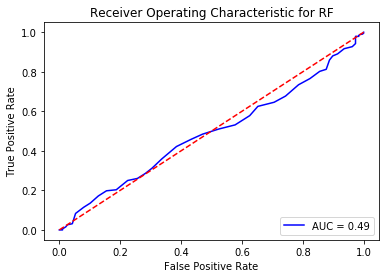

In [16]:
predModel(X_train, y_train, X_test, y_test, modelType='RF')

Accuracy for model XGB is: 0.49
ROC AUC for model XGB is: 0.49
Model training time is 1.236 seconds

Confusion matrix:
[[ 51 136]
 [ 56 136]]


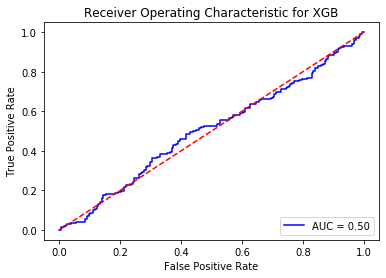

In [17]:
predModel(X_train, y_train, X_test, y_test, modelType='XGB')

Accuracy for model LogReg is: 0.51
ROC AUC for model LogReg is: 0.50
Model training time is 0.014 seconds

Confusion matrix:
[[  0 187]
 [  0 192]]


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


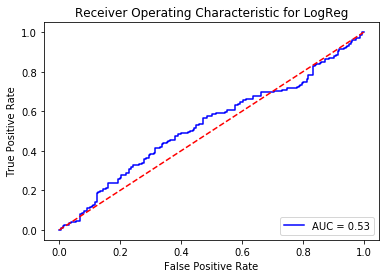

In [18]:
predModel(X_train, y_train, X_test, y_test, modelType='LogReg')

Accuracy for model SVC is: 0.51
ROC AUC for model SVC is: 0.50
Model training time is 0.291 seconds

Confusion matrix:
[[  0 187]
 [  0 192]]


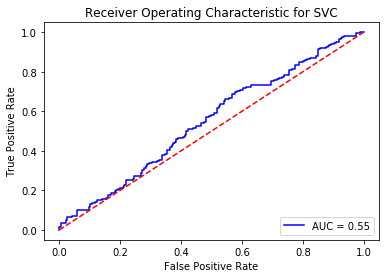

In [19]:
predModel(X_train, y_train, X_test, y_test, modelType='SVC')

Accuracy for model MLP is: 0.51
ROC AUC for model MLP is: 0.50
Model training time is 0.030 seconds

Confusion matrix:
[[  0 187]
 [  0 192]]


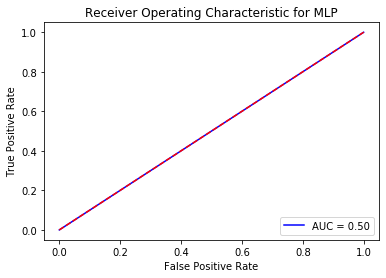

In [20]:
predModel(X_train, y_train, X_test, y_test, modelType='MLP')

### print output